In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Importing Dataset

In [60]:
# Importing training dataset

df_train = pd.read_csv("/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A3/Data/trainset.csv")
df_train


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900
...,...,...,...,...,...,...,...
1254,2017-12-22,1061.109985,1064.199951,1059.439941,1060.119995,1060.119995,755100
1255,2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
1256,2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
1257,2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100


In [61]:
# Importing testing dataset

df_test = pd.read_csv("/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A3/Data/testset.csv")
df_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1048.339966,1066.939941,1045.229980,1065.000000,1065.000000,1237600
1,2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1082.479980,1430200
2,2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1086.400024,1004600
3,2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1102.229980,1279100
4,2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1106.939941,1047600
...,...,...,...,...,...,...,...
120,2018-06-25,1143.599976,1143.910034,1112.780029,1124.810059,1124.810059,2157300
121,2018-06-26,1128.000000,1133.209961,1116.659058,1118.459961,1118.459961,1563200
122,2018-06-27,1121.339966,1131.836060,1103.619995,1103.979980,1103.979980,1293900
123,2018-06-28,1102.089966,1122.310059,1096.010010,1114.219971,1114.219971,1072400


# Data preprocessing

In [62]:
# Splitting the data into training, validation in a 75:25 ratio
train_size = int(len(df_train["Date"]) * 0.75)
validation_size = int(len(df_train["Date"]) * 0.25)

df_train, df_val = df_train[:train_size], df_train[train_size:]

# Checking the size of each set
len_train, len_validation = len(df_train), len(df_val)
len_train, len_validation

(944, 315)

In [63]:
# Convert the dataframes to sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

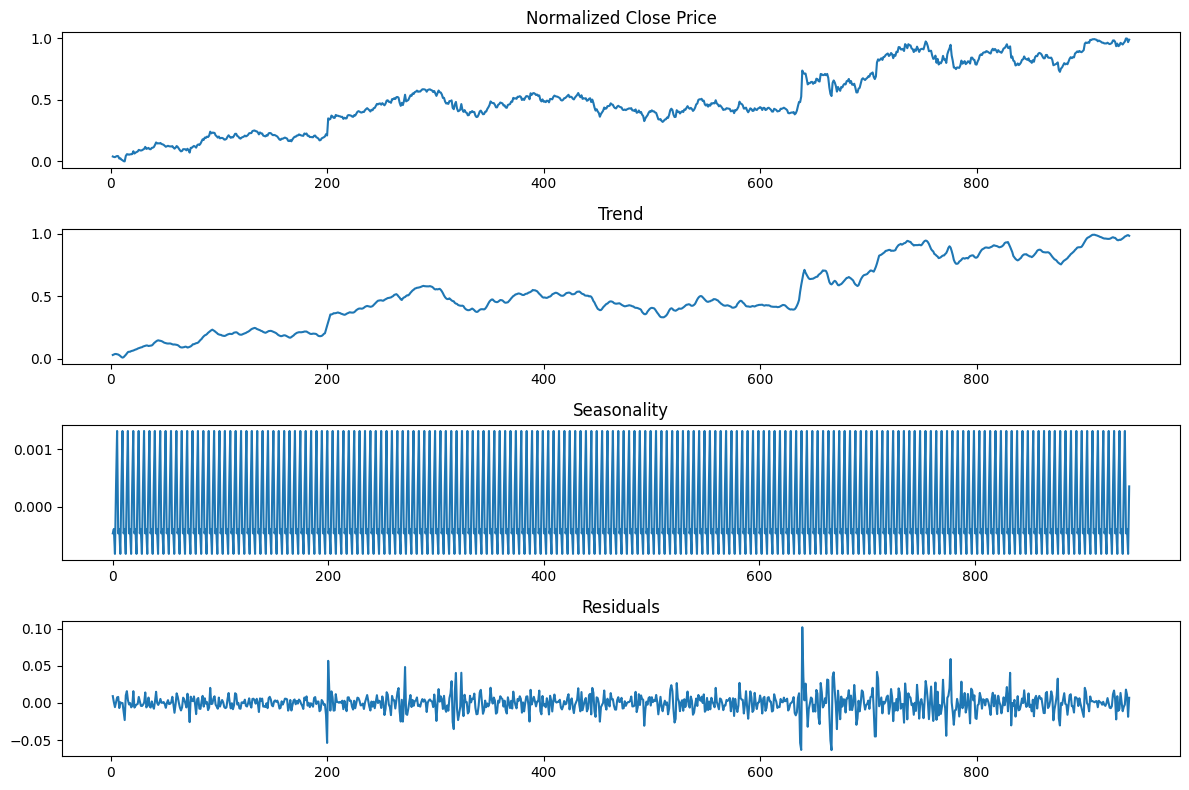

In [64]:
# Training Dataset

# Drop date
df_train = df_train.drop('Date', axis=1)

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)

# Convert back to DataFrame
df_train = pd.DataFrame(df_train_scaled, columns=df_train.columns)

# Time Series Decomposition
decomposition = seasonal_decompose(df_train['Close'], model='additive', period=5)
trend_train = decomposition.trend
seasonal_train = decomposition.seasonal
df_train['Residual'] = decomposition.resid

# Dropping NaN values that may have been introduced by decomposition
df_train.dropna(inplace=True)

# Plotting the decomposition
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
df_train['Close'].plot(ax=ax[0], title='Normalized Close Price')
trend_train.plot(ax=ax[1], title='Trend')
seasonal_train.plot(ax=ax[2], title='Seasonality')
df_train['Residual'].plot(ax=ax[3], title='Residuals')
plt.tight_layout()
plt.show()


In [65]:
# Creating Sequence
n_steps = 10
X_train, y_train = create_sequences(df_train['Residual'].values, n_steps)

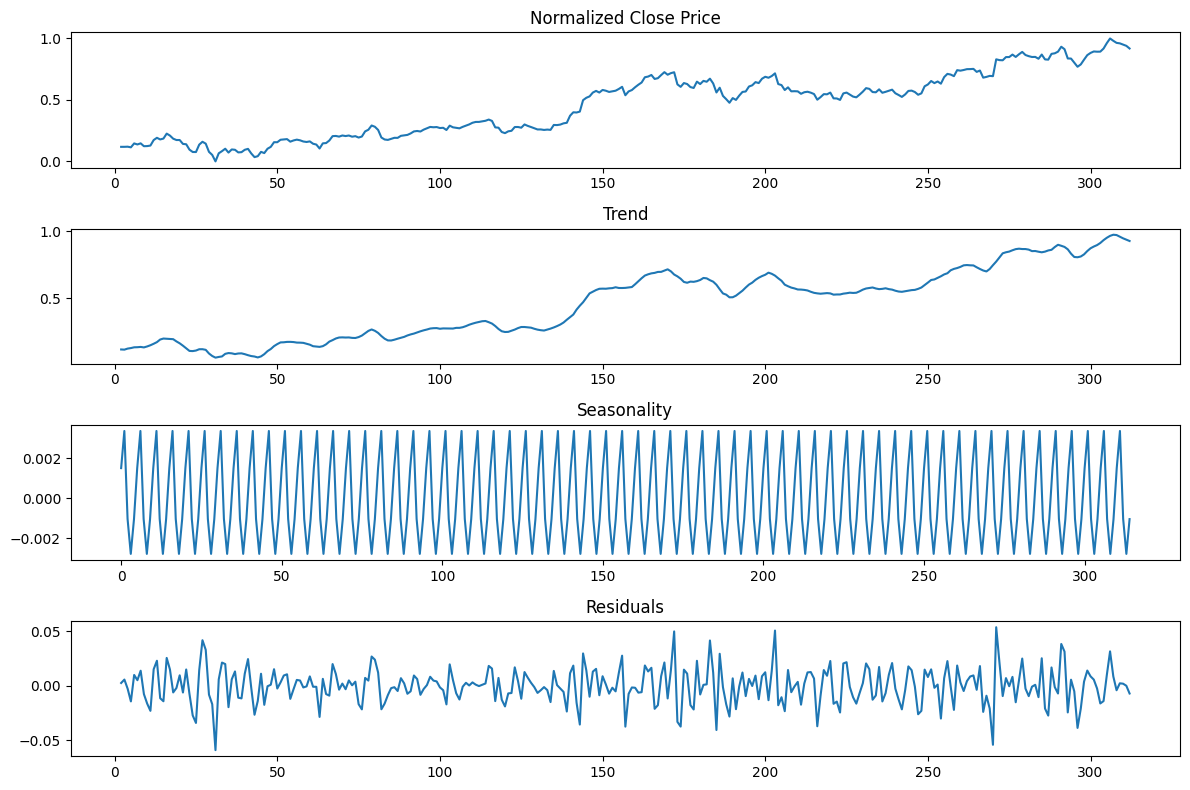

In [66]:
# Validation set

# Drop date
df_val = df_val.drop('Date', axis=1)

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
df_validation_scaled = scaler.fit_transform(df_val)

# Convert back to DataFrame
df_val = pd.DataFrame(df_validation_scaled, columns=df_val.columns)

# Time Series Decomposition
decomposition = seasonal_decompose(df_val['Close'], model='additive', period=5)
trend_val = decomposition.trend
seasonal_val = decomposition.seasonal
df_val['Residual'] = decomposition.resid

# Dropping NaN values that may have been introduced by decomposition
df_val.dropna(inplace=True)

# Plotting the decomposition
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
df_val['Close'].plot(ax=ax[0], title='Normalized Close Price')
trend_val.plot(ax=ax[1], title='Trend')
seasonal_val.plot(ax=ax[2], title='Seasonality')
df_val['Residual'].plot(ax=ax[3], title='Residuals')
plt.tight_layout()
plt.show()


In [67]:
# Creating Sequence

X_val, y_val = create_sequences(df_val['Residual'].values, n_steps)

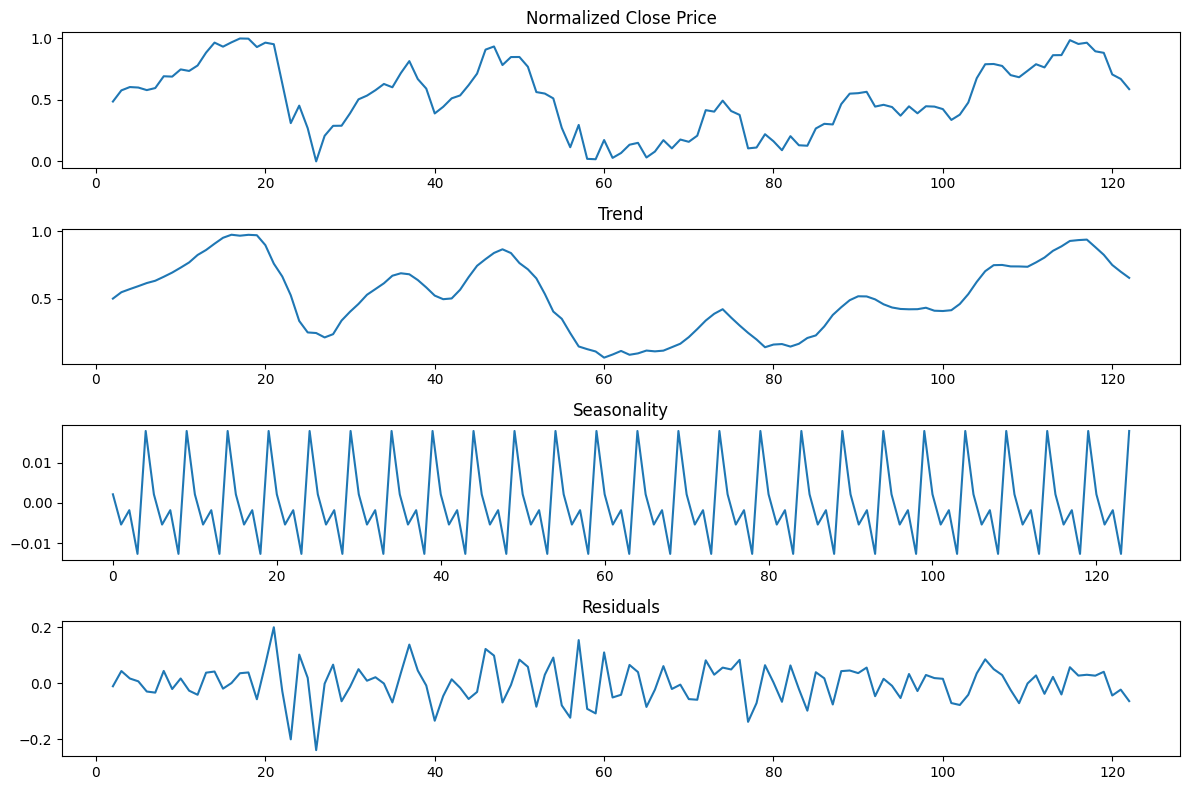

In [68]:
# Test set

# Drop date
df_test = df_test.drop('Date', axis=1)

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
df_test_scaled = scaler.fit_transform(df_test)

# Convert back to DataFrame
df_test = pd.DataFrame(df_test_scaled, columns=df_test.columns)

# Time Series Decomposition
decomposition = seasonal_decompose(df_test['Close'], model='additive', period=5)
trend_test = decomposition.trend
seasonal_test = decomposition.seasonal
resid_test = decomposition.resid
df_test['Residual'] = decomposition.resid

# Dropping NaN values that may have been introduced by decomposition
df_test.dropna(inplace=True)

# Plotting the decomposition
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
df_test['Close'].plot(ax=ax[0], title='Normalized Close Price')
trend_test.plot(ax=ax[1], title='Trend')
seasonal_test.plot(ax=ax[2], title='Seasonality')
df_test['Residual'].plot(ax=ax[3], title='Residuals')
plt.tight_layout()
plt.show()


In [69]:
# Repeat the same process for test data

X_test, y_test = create_sequences(df_test['Residual'].values, n_steps)

# Model Implementation

## Basic RNN

Epoch 1/50
30/30 [==============================] - 2s 13ms/step - loss: 1.4722e-04 - val_loss: 2.3595e-04
Epoch 2/50
30/30 [==============================] - 0s 5ms/step - loss: 1.3497e-04 - val_loss: 2.3350e-04
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 1.3349e-04 - val_loss: 2.4154e-04
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 1.3976e-04 - val_loss: 2.3786e-04
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 1.3002e-04 - val_loss: 2.3117e-04
Epoch 6/50
30/30 [==============================] - 0s 5ms/step - loss: 1.3365e-04 - val_loss: 2.3314e-04
Epoch 7/50
30/30 [==============================] - 0s 5ms/step - loss: 1.3813e-04 - val_loss: 2.4758e-04
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 1.2789e-04 - val_loss: 2.3018e-04
Epoch 9/50
30/30 [==============================] - 0s 5ms/step - loss: 1.2733e-04 - val_loss: 2.3417e-04
Epoch 10/50
30/30 [==========================

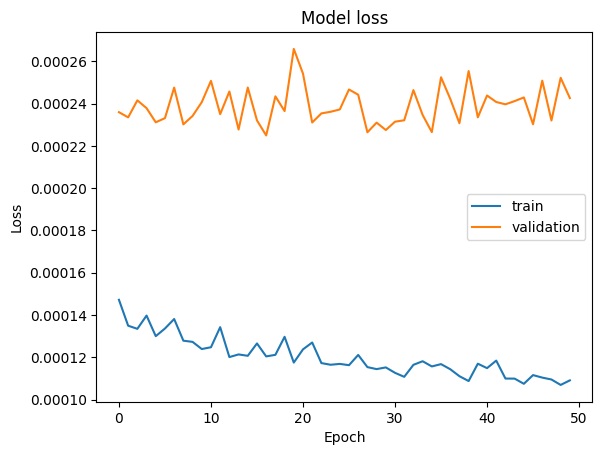

In [71]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history_Basic = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Plotting the training and validation loss
plt.plot(history_Basic.history['loss'], label='train')
plt.plot(history_Basic.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Best epoch:  17
Epoch 1/17
30/30 [==============================] - 1s 14ms/step - loss: 1.4946e-04 - val_loss: 2.4727e-04
Epoch 2/17
30/30 [==============================] - 0s 5ms/step - loss: 1.4677e-04 - val_loss: 2.3868e-04
Epoch 3/17
30/30 [==============================] - 0s 6ms/step - loss: 1.3486e-04 - val_loss: 2.3934e-04
Epoch 4/17
30/30 [==============================] - 0s 10ms/step - loss: 1.3651e-04 - val_loss: 2.3879e-04
Epoch 5/17
30/30 [==============================] - 0s 10ms/step - loss: 1.3297e-04 - val_loss: 2.2987e-04
Epoch 6/17
30/30 [==============================] - 0s 13ms/step - loss: 1.2683e-04 - val_loss: 2.2917e-04
Epoch 7/17
30/30 [==============================] - 0s 9ms/step - loss: 1.2654e-04 - val_loss: 2.2776e-04
Epoch 8/17
30/30 [==============================] - 0s 7ms/step - loss: 1.2647e-04 - val_loss: 2.4931e-04
Epoch 9/17
30/30 [==============================] - 0s 6ms/step - loss: 1.2458e-04 - val_loss: 2.3792e-04
Epoch 10/17
30/30 [=======

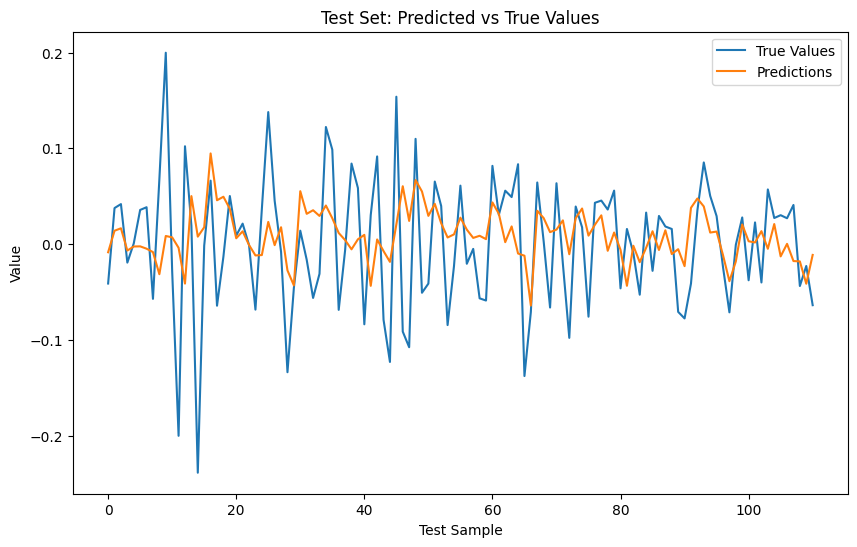

In [73]:
# 1. Identify the Best Epoch
best_epoch = np.argmin(history_Basic.history['val_loss']) + 1
print("Best epoch: ", best_epoch)

# 2. Retrain the Model with the Best Epoch
model_final = Sequential()
model_final.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, 1)))
model_final.add(Dense(1))
model_final.compile(optimizer=Adam(), loss='mean_squared_error')
model_final.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_val, y_val))

# 3. Make Predictions on the Test Set
predicted_test_simple = model_final.predict(X_test)

# 4. Plot the Predictions Against Real Values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_test_simple, label='Predictions')
plt.title('Test Set: Predicted vs True Values')
plt.ylabel('Value')
plt.xlabel('Test Sample')
plt.legend()
plt.show()


In [74]:
# Calculate MSE
Basic_mse = round(mean_squared_error(y_test, predicted_test_simple), 4)
print("Mean Squared Error (MSE):", Basic_mse)

# Calculate MAE
Basic_mae = round(mean_absolute_error(y_test, predicted_test_simple), 4)
print("Mean Absolute Error (MAE):", Basic_mae)

# Calculate RMSE
Basic_rmse = round(mean_squared_error(y_test, predicted_test_simple, squared=False), 4)
print("Root Mean Squared Error (RMSE):", Basic_rmse)

# Calculate R^2
Basic_r2 = round(r2_score(y_test, predicted_test_simple), 4)
print("R-squared (R^2):", Basic_r2)

Mean Squared Error (MSE): 0.0047
Mean Absolute Error (MAE): 0.0529
Root Mean Squared Error (RMSE): 0.0683
R-squared (R^2): 0.0212


## GRU

Epoch 1/50
30/30 [==============================] - 2s 18ms/step - loss: 1.5838e-04 - val_loss: 2.7231e-04
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 1.6462e-04 - val_loss: 2.7092e-04
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 1.5905e-04 - val_loss: 2.6928e-04
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 1.5863e-04 - val_loss: 2.7264e-04
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 1.5872e-04 - val_loss: 2.6765e-04
Epoch 6/50
30/30 [==============================] - 0s 14ms/step - loss: 1.5763e-04 - val_loss: 2.6791e-04
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 1.5694e-04 - val_loss: 2.6619e-04
Epoch 8/50
30/30 [==============================] - 1s 17ms/step - loss: 1.5478e-04 - val_loss: 2.6997e-04
Epoch 9/50
30/30 [==============================] - 1s 25ms/step - loss: 1.5417e-04 - val_loss: 2.6392e-04
Epoch 10/50
30/30 [===================

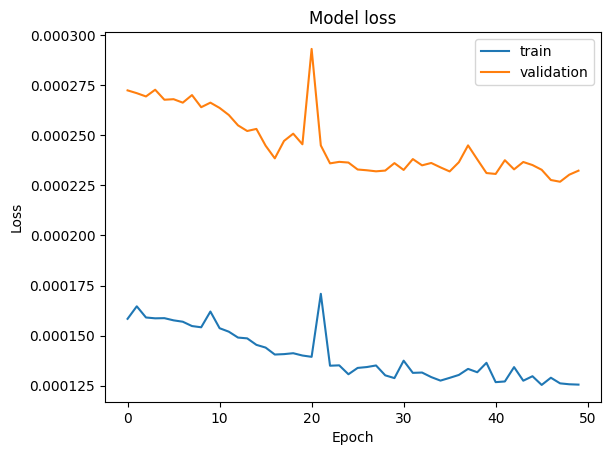

In [75]:
# Build the GRU model
model_GRU = Sequential()
model_GRU.add(GRU(50, activation='relu', input_shape=(n_steps, 1)))
model_GRU.add(Dense(1))

# Compile the model
model_GRU.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history_GRU = model_GRU.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Plotting the training and validation loss
plt.plot(history_GRU.history['loss'], label='train')
plt.plot(history_GRU.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Best epoch:  48
Epoch 1/48
30/30 [==============================] - 2s 17ms/step - loss: 1.6546e-04 - val_loss: 2.6872e-04
Epoch 2/48
30/30 [==============================] - 0s 8ms/step - loss: 1.5591e-04 - val_loss: 2.6804e-04
Epoch 3/48
30/30 [==============================] - 0s 11ms/step - loss: 1.5713e-04 - val_loss: 2.6633e-04
Epoch 4/48
30/30 [==============================] - 0s 9ms/step - loss: 1.5762e-04 - val_loss: 2.6697e-04
Epoch 5/48
30/30 [==============================] - 0s 10ms/step - loss: 1.5741e-04 - val_loss: 2.6683e-04
Epoch 6/48
30/30 [==============================] - 0s 10ms/step - loss: 1.5508e-04 - val_loss: 2.7804e-04
Epoch 7/48
30/30 [==============================] - 0s 11ms/step - loss: 1.5918e-04 - val_loss: 2.7396e-04
Epoch 8/48
30/30 [==============================] - 0s 11ms/step - loss: 1.5745e-04 - val_loss: 2.6500e-04
Epoch 9/48
30/30 [==============================] - 0s 11ms/step - loss: 1.5416e-04 - val_loss: 2.6323e-04
Epoch 10/48
30/30 [====

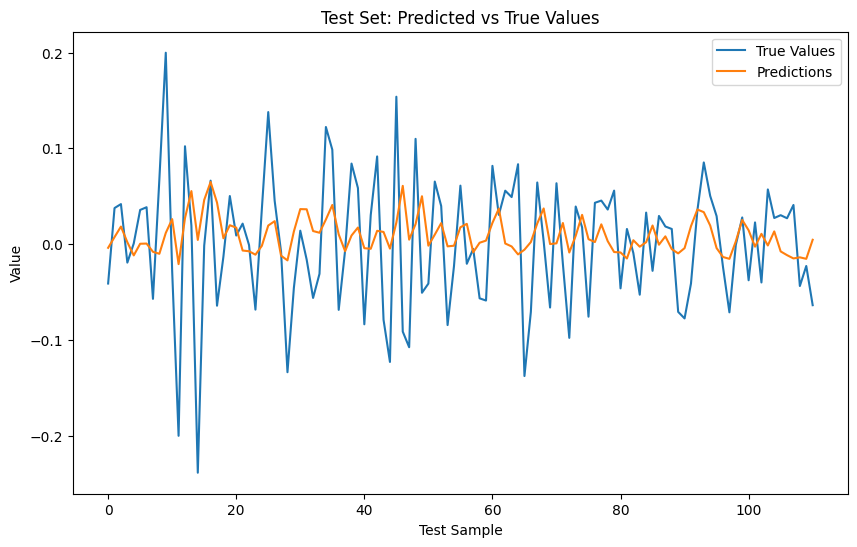

In [76]:
# 1. Identify the Best Epoch
best_epoch_GRU = np.argmin(history_GRU.history['val_loss']) + 1
print("Best epoch: ", best_epoch_GRU)

# 2. Retrain the Model with the Best Epoch
model_final_GRU = Sequential()
model_final_GRU.add(GRU(50, activation='relu', input_shape=(n_steps, 1)))
model_final_GRU.add(Dense(1))
model_final_GRU.compile(optimizer=Adam(), loss='mean_squared_error')
model_final_GRU.fit(X_train, y_train, epochs=best_epoch_GRU, validation_data=(X_val, y_val))

# 3. Make Predictions on the Test Set
predicted_test_GRU = model_final_GRU.predict(X_test)

# 4. Plot the Predictions Against Real Values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_test_GRU, label='Predictions')
plt.title('Test Set: Predicted vs True Values')
plt.ylabel('Value')
plt.xlabel('Test Sample')
plt.legend()
plt.show()


In [77]:
# Calculate and display the metrics
GRU_mse = round(mean_squared_error(y_test, predicted_test_GRU), 4)
print("Mean Squared Error (MSE):", GRU_mse)

GRU_mae = round(mean_absolute_error(y_test, predicted_test_GRU), 4)
print("Mean Absolute Error (MAE):", GRU_mae)

GRU_rmse = round(mean_squared_error(y_test, predicted_test_GRU, squared=False), 4)
print("Root Mean Squared Error (RMSE):", GRU_rmse)

GRU_r2 = round(r2_score(y_test, predicted_test_GRU), 4)
print("R-squared (R^2):", GRU_r2)

Mean Squared Error (MSE): 0.0045
Mean Absolute Error (MAE): 0.0532
Root Mean Squared Error (RMSE): 0.067
R-squared (R^2): 0.0578


## LSTM

Epoch 1/50
30/30 [==============================] - 2s 26ms/step - loss: 1.6019e-04 - val_loss: 2.6605e-04
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 1.5500e-04 - val_loss: 2.6283e-04
Epoch 3/50
30/30 [==============================] - 0s 13ms/step - loss: 1.5462e-04 - val_loss: 2.6342e-04
Epoch 4/50
30/30 [==============================] - 0s 14ms/step - loss: 1.5757e-04 - val_loss: 2.6397e-04
Epoch 5/50
30/30 [==============================] - 0s 13ms/step - loss: 1.5846e-04 - val_loss: 2.6248e-04
Epoch 6/50
30/30 [==============================] - 0s 13ms/step - loss: 1.5551e-04 - val_loss: 2.6112e-04
Epoch 7/50
30/30 [==============================] - 0s 15ms/step - loss: 1.5207e-04 - val_loss: 2.6600e-04
Epoch 8/50
30/30 [==============================] - 0s 15ms/step - loss: 1.5109e-04 - val_loss: 2.6016e-04
Epoch 9/50
30/30 [==============================] - 0s 14ms/step - loss: 1.5064e-04 - val_loss: 2.5601e-04
Epoch 10/50
30/30 [==================

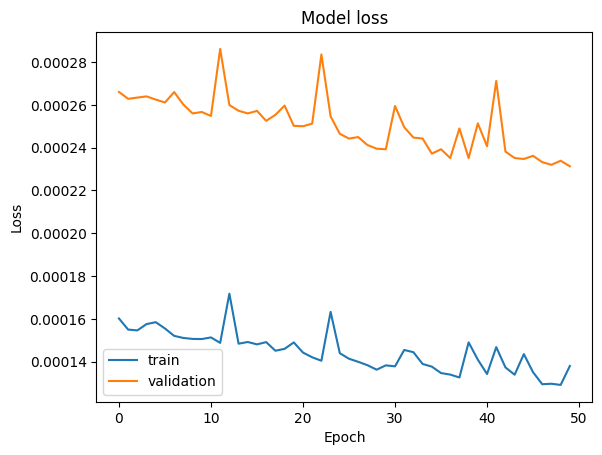

In [78]:
# Build the LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model_LSTM.add(Dense(1))

# Compile the model
model_LSTM.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Plotting the training and validation loss
plt.plot(history_LSTM.history['loss'], label='train')
plt.plot(history_LSTM.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Best epoch:  50
Epoch 1/50
30/30 [==============================] - 2s 17ms/step - loss: 1.5908e-04 - val_loss: 2.8164e-04
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 1.6201e-04 - val_loss: 2.6849e-04
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 1.5795e-04 - val_loss: 2.6487e-04
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 1.5594e-04 - val_loss: 2.6458e-04
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 1.5508e-04 - val_loss: 2.6248e-04
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 1.5370e-04 - val_loss: 2.6068e-04
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 1.5436e-04 - val_loss: 2.6848e-04
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 1.5625e-04 - val_loss: 2.6202e-04
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 1.5901e-04 - val_loss: 2.6436e-04
Epoch 10/50
30/30 [======

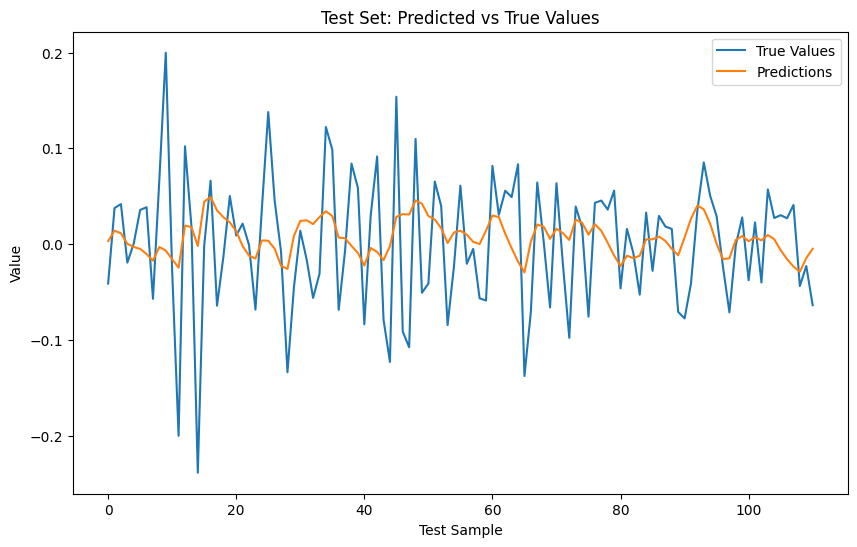

In [79]:
# 1. Identify the Best Epoch
best_epoch_LSTM = np.argmin(history_LSTM.history['val_loss']) + 1
print("Best epoch: ", best_epoch_LSTM)

# 2. Retrain the Model with the Best Epoch
model_final_LSTM = Sequential()
model_final_LSTM.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model_final_LSTM.add(Dense(1))
model_final_LSTM.compile(optimizer=Adam(), loss='mean_squared_error')
model_final_LSTM.fit(X_train, y_train, epochs=best_epoch_LSTM, validation_data=(X_val, y_val))

# 3. Make Predictions on the Test Set
predicted_test_LSTM = model_final_LSTM.predict(X_test)

# 4. Plot the Predictions Against Real Values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_test_LSTM, label='Predictions')
plt.title('Test Set: Predicted vs True Values')
plt.ylabel('Value')
plt.xlabel('Test Sample')
plt.legend()
plt.show()

In [80]:
# Calculate and display the metrics
LSTM_mse = round(mean_squared_error(y_test, predicted_test_LSTM), 4)
print("Mean Squared Error (MSE):", LSTM_mse)

LSTM_mae = round(mean_absolute_error(y_test, predicted_test_LSTM), 4)
print("Mean Absolute Error (MAE):", LSTM_mae)

LSTM_rmse = round(mean_squared_error(y_test, predicted_test_LSTM, squared=False), 4)
print("Root Mean Squared Error (RMSE):", LSTM_rmse)

LSTM_r2 = round(r2_score(y_test, predicted_test_LSTM), 4)
print("R-squared (R^2):", LSTM_r2)


Mean Squared Error (MSE): 0.0044
Mean Absolute Error (MAE): 0.0519
Root Mean Squared Error (RMSE): 0.0663
R-squared (R^2): 0.0776


## Bidirectional LSTM

Epoch 1/50
30/30 [==============================] - 3s 26ms/step - loss: 1.6284e-04 - val_loss: 2.6907e-04
Epoch 2/50
30/30 [==============================] - 1s 17ms/step - loss: 1.5633e-04 - val_loss: 2.7391e-04
Epoch 3/50
30/30 [==============================] - 1s 20ms/step - loss: 1.5761e-04 - val_loss: 2.6496e-04
Epoch 4/50
30/30 [==============================] - 1s 22ms/step - loss: 1.5973e-04 - val_loss: 2.7957e-04
Epoch 5/50
30/30 [==============================] - 1s 37ms/step - loss: 1.6193e-04 - val_loss: 2.7523e-04
Epoch 6/50
30/30 [==============================] - 1s 38ms/step - loss: 1.5876e-04 - val_loss: 2.6631e-04
Epoch 7/50
30/30 [==============================] - 1s 25ms/step - loss: 1.5470e-04 - val_loss: 2.6533e-04
Epoch 8/50
30/30 [==============================] - 1s 25ms/step - loss: 1.5683e-04 - val_loss: 2.6272e-04
Epoch 9/50
30/30 [==============================] - 1s 24ms/step - loss: 1.5586e-04 - val_loss: 2.6113e-04
Epoch 10/50
30/30 [==================

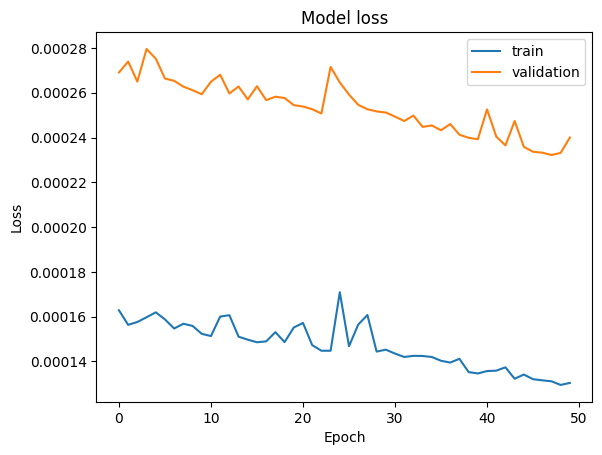

In [81]:
# Build the Bidirectional LSTM model
model_BiLSTM = Sequential()
model_BiLSTM.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, 1)))
model_BiLSTM.add(Dense(1))

# Compile the model
model_BiLSTM.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history_BiLSTM = model_BiLSTM.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Plotting the training and validation loss
plt.plot(history_BiLSTM.history['loss'], label='train')
plt.plot(history_BiLSTM.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Best epoch:  48
Epoch 1/48
30/30 [==============================] - 5s 25ms/step - loss: 1.6166e-04 - val_loss: 2.7341e-04
Epoch 2/48
30/30 [==============================] - 0s 12ms/step - loss: 1.5944e-04 - val_loss: 2.7308e-04
Epoch 3/48
30/30 [==============================] - 0s 12ms/step - loss: 1.6351e-04 - val_loss: 2.6858e-04
Epoch 4/48
30/30 [==============================] - 0s 13ms/step - loss: 1.6330e-04 - val_loss: 2.7674e-04
Epoch 5/48
30/30 [==============================] - 0s 13ms/step - loss: 1.5675e-04 - val_loss: 2.6924e-04
Epoch 6/48
30/30 [==============================] - 0s 13ms/step - loss: 1.6465e-04 - val_loss: 2.7201e-04
Epoch 7/48
30/30 [==============================] - 0s 13ms/step - loss: 1.6187e-04 - val_loss: 2.7157e-04
Epoch 8/48
30/30 [==============================] - 0s 14ms/step - loss: 1.6115e-04 - val_loss: 2.7309e-04
Epoch 9/48
30/30 [==============================] - 0s 12ms/step - loss: 1.5996e-04 - val_loss: 2.7012e-04
Epoch 10/48
30/30 [==

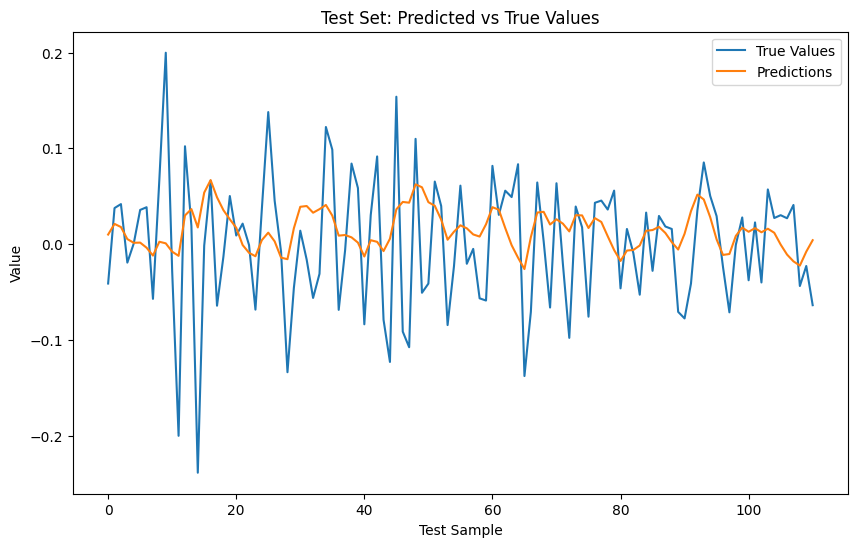

In [82]:
# 1. Identify the Best Epoch
best_epoch_BiLSTM = np.argmin(history_BiLSTM.history['val_loss']) + 1
print("Best epoch: ", best_epoch_BiLSTM)

# 2. Retrain the Model with the Best Epoch
model_final_BiLSTM = Sequential()
model_final_BiLSTM.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, 1)))
model_final_BiLSTM.add(Dense(1))
model_final_BiLSTM.compile(optimizer=Adam(), loss='mean_squared_error')
model_final_BiLSTM.fit(X_train, y_train, epochs=best_epoch_BiLSTM, validation_data=(X_val, y_val))

# 3. Make Predictions on the Test Set
predicted_test_BiLSTM = model_final_BiLSTM.predict(X_test)

# 4. Plot the Predictions Against Real Values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_test_BiLSTM, label='Predictions')
plt.title('Test Set: Predicted vs True Values')
plt.ylabel('Value')
plt.xlabel('Test Sample')
plt.legend()
plt.show()


In [83]:
# Calculate and display the metrics
BiLSTM_mse = round(mean_squared_error(y_test, predicted_test_BiLSTM), 4)
print("Mean Squared Error (MSE):", BiLSTM_mse)

BiLSTM_mae = round(mean_absolute_error(y_test, predicted_test_BiLSTM), 4)
print("Mean Absolute Error (MAE):", BiLSTM_mae)

BiLSTM_rmse = round(mean_squared_error(y_test, predicted_test_BiLSTM, squared=False), 4)
print("Root Mean Squared Error (RMSE):", BiLSTM_rmse)

BiLSTM_r2 = round(r2_score(y_test, predicted_test_BiLSTM), 4)
print("R-squared (R^2):", BiLSTM_r2)

Mean Squared Error (MSE): 0.0047
Mean Absolute Error (MAE): 0.0528
Root Mean Squared Error (RMSE): 0.0685
R-squared (R^2): 0.0169


# Results

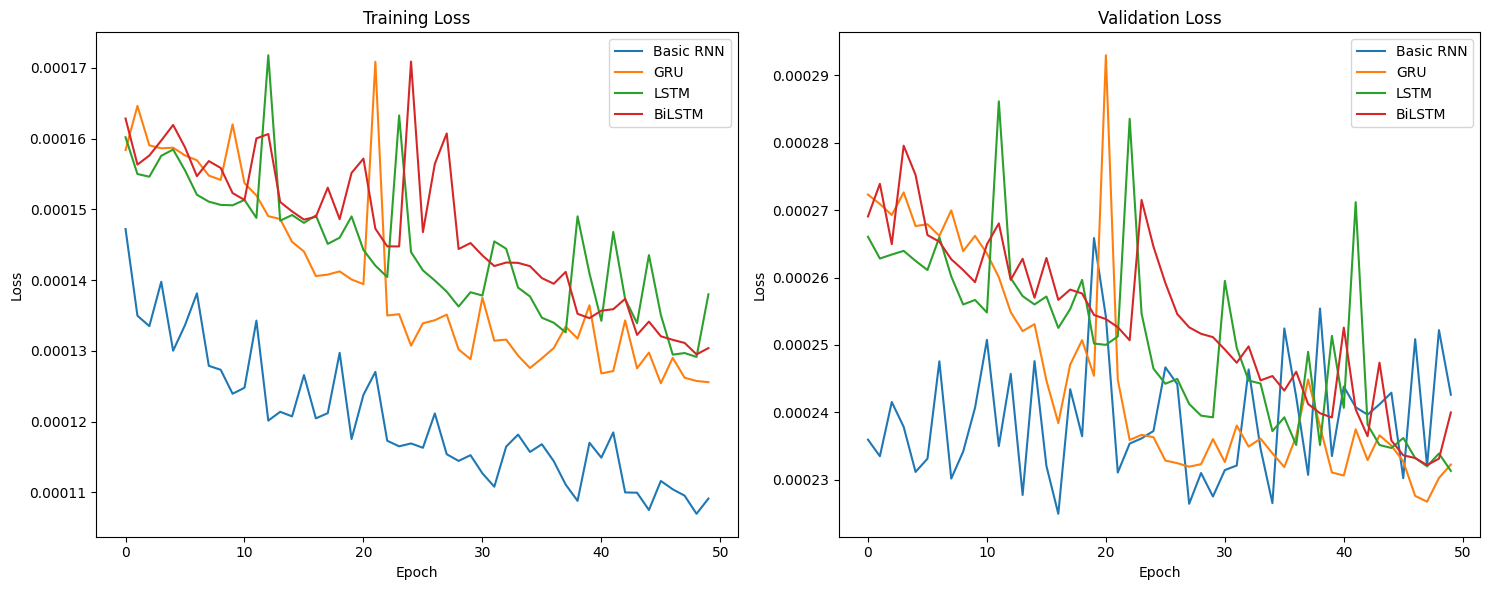

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Training Loss Plot
axs[0].plot(history_Basic.history['loss'], label='Basic RNN')
axs[0].plot(history_GRU.history['loss'], label='GRU')
axs[0].plot(history_LSTM.history['loss'], label='LSTM')
axs[0].plot(history_BiLSTM.history['loss'], label='BiLSTM')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Validation Loss Plot
axs[1].plot(history_Basic.history['val_loss'], label='Basic RNN')
axs[1].plot(history_GRU.history['val_loss'], label='GRU')
axs[1].plot(history_LSTM.history['val_loss'], label='LSTM')
axs[1].plot(history_BiLSTM.history['val_loss'], label='BiLSTM')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


In [85]:
# Create a dictionary with the metrics
data = {
    'Model': ['Basic RNN', 'GRU', 'LSTM', 'BiLSTM'],
    'MSE': [Basic_mse, GRU_mse, LSTM_mse, BiLSTM_mse],
    'MAE': [Basic_mae, GRU_mae, LSTM_mae, BiLSTM_mae],
    'RMSE': [Basic_rmse, GRU_rmse, LSTM_rmse, BiLSTM_rmse],
    'R^2': [Basic_r2, GRU_r2, LSTM_r2, BiLSTM_r2]
}

# Create DataFrame
df_metrics = pd.DataFrame(data)

# Display the DataFrame
print(df_metrics)

       Model     MSE     MAE    RMSE     R^2
0  Basic RNN  0.0047  0.0529  0.0683  0.0212
1        GRU  0.0045  0.0532  0.0670  0.0578
2       LSTM  0.0044  0.0519  0.0663  0.0776
3     BiLSTM  0.0047  0.0528  0.0685  0.0169


LSTM is the best model.

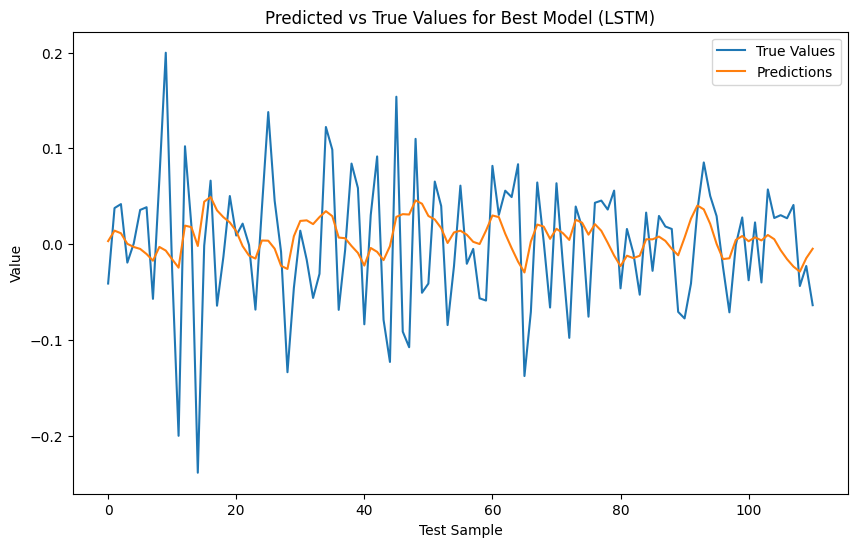

In [86]:
# Plot the Predictions Against Real Values for the best model
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_test_LSTM, label='Predictions')
plt.title('Predicted vs True Values for Best Model (LSTM)')
plt.ylabel('Value')
plt.xlabel('Test Sample')
plt.legend()
plt.show()